# Team 63
## Hypothests Testing Mobility and COVID Infection Rate During Pandemic

### Texas Mobility During COVID Pandemic

During the pandemic we had shutdown periods around the globe to reduce the spread of the virus.  We would like to see where people were going during the pandemic and if there are any changes related to shutdown periods during that time period.

In [61]:
# Load relevant packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as sm
import warnings

warnings.filterwarnings("ignore")  # Suppress all warnings

## Data Background

We are using data google captured of mobility during the pandemic.  This data compared each day to the baseline of mobility for various categories to show where people were going during the year.  The baseline is limited to the first 5 weeks of the year before changes were made.  The data looks at the count of visits to parks, workplace, transit, grocery/pharmacy, and retail/recreation. It also tracks residential as time spent at home compared to the baseline.  **The baseline is January 2020 and the beginning of February 2020** before any shutdowns went in affect. Note: In some locations, weather in January and February is vastly different from weather in March or April and could impact things like park visits. Since we are only considering counties in Texas, the difference in average temperature may have an affect but since the average high difference is +10 degrees per month, it may be negligible.

In [62]:
#read mobility report csv downloaded from Google
mobility = pd.read_excel("../data/mobilityreport01092021_original.xlsx")
print(mobility.columns)
print(mobility.info())

Index(['country_region_code', 'country_region', 'sub_region_1', 'sub_region_2',
       'metro_area', 'iso_3166_2_code', 'census_fips_code', 'date',
       'retail_and_recreation_percent_change_from_baseline',
       'grocery_and_pharmacy_percent_change_from_baseline',
       'parks_percent_change_from_baseline',
       'transit_stations_percent_change_from_baseline',
       'workplaces_percent_change_from_baseline',
       'residential_percent_change_from_baseline'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11200 entries, 0 to 11199
Data columns (total 14 columns):
 #   Column                                              Non-Null Count  Dtype         
---  ------                                              --------------  -----         
 0   country_region_code                                 11032 non-null  object        
 1   country_region                                      11032 non-null  object        
 2   sub_region_1                            

In [64]:
mobility.head(5)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,iso_3166_2_code,census_fips_code,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,Texas,Atascosa County,NaN,NaN,48013.0,2020-02-15,3.0,-1.0,NaN,3.0,3.0,NaN
1,US,United States,Texas,Atascosa County,NaN,NaN,48013.0,2020-02-16,8.0,2.0,NaN,9.0,-3.0,NaN
2,US,United States,Texas,Atascosa County,NaN,NaN,48013.0,2020-02-17,1.0,3.0,NaN,16.0,-18.0,3.0
3,US,United States,Texas,Atascosa County,NaN,NaN,48013.0,2020-02-18,1.0,-1.0,NaN,10.0,0.0,-1.0
4,US,United States,Texas,Atascosa County,NaN,NaN,48013.0,2020-02-19,0.0,-3.0,NaN,2.0,3.0,1.0


We decided to look at the major metroplex areas and their surrounding counties to see what people were doing.  I created a list of counties for the state, and each metroplex to use when filtering data.  We need to create datasets to find the avg percent from baseline for each category.  

In [65]:
#create list of counties that make up Texas cities and counties within major metroplex areas
Texas_Counties = ['Bastrop County','Bexar County','Caldwell County','Comal County','Guadalupe County','Hays County','Travis County','Williamson County',
    'Collin County', 'Dallas County', 'Denton County', 'Ellis County', 'Hood County', 'Hunt County', 'Johnson County', 'Kaufman County', 'Parker County', 'Rockwall County', 'Somervell County', 'Tarrant County', 'Wise County',
    'Austin County', 'Brazoria County', 'Chambers County', 'Fort Bend County', 'Galveston County', 'Harris County', 'Liberty County', 'Montgomery County', 'Waller County',
    'Atascosa County','Bandera County','Kendall County','Medina County','Wilson County']
Austin_Metroplex =  ['Bastrop County','Caldwell County','Hays County','Travis County','Williamson County']
Dallas_Metroplex = ['Collin County', 'Dallas County', 'Denton County', 'Ellis County', 'Hood County', 'Hunt County', 'Johnson County', 'Kaufman County', 'Parker County', 'Rockwall County', 'Somervell County', 'Tarrant County', 'Wise County']
Houston_Metroplex = ['Austin County', 'Brazoria County', 'Chambers County', 'Fort Bend County', 'Galveston County', 'Harris County', 'Liberty County', 'Montgomery County', 'Waller County']
San_Antonio_Metroplex = ['Atascosa County','Bandera County','Bexar County','Comal County','Guadalupe County','Kendall County','Medina County','Wilson County']

In [66]:
#create new dataset filtering by all texas counties in our scope from Texas_Counties list using na=False for nan in filtered column
mobility_tx = mobility[mobility['sub_region_1'].str.contains('Texas', na=False)]
mobility_tx = mobility_tx[mobility_tx['sub_region_2'].isin(Texas_Counties)]
#get rid of null dates
mobility_tx = mobility_tx.dropna(subset=['date'])
#delete iso_3166_2_code and census_fips_code column since we do not need it
mobility_tx.drop(['iso_3166_2_code', 'census_fips_code'], axis=1, inplace=True)
#metro_area was not populated but we will populate based on counties we chose for each metroplex
#create conditions list
conditions = [(mobility_tx['sub_region_2'].isin(Austin_Metroplex)),
             (mobility_tx['sub_region_2'].isin(Dallas_Metroplex)),
             (mobility_tx['sub_region_2'].isin(Houston_Metroplex)),
             (mobility_tx['sub_region_2'].isin(San_Antonio_Metroplex))]
#create list of metroplex values
metro = ['Austin Metroplex', 'Dallas Metroplex', 'Houston Metroplex', 'San Antonio Metroplex']
#update metro_area with values based on conditions
mobility_tx['metro_area'] = np.select(conditions, metro)
mobility_tx.head(5)

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,date,retail_and_recreation_percent_change_from_baseline,grocery_and_pharmacy_percent_change_from_baseline,parks_percent_change_from_baseline,transit_stations_percent_change_from_baseline,workplaces_percent_change_from_baseline,residential_percent_change_from_baseline
0,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-15,3.0,-1.0,NaN,3.0,3.0,NaN
1,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-16,8.0,2.0,NaN,9.0,-3.0,NaN
2,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-17,1.0,3.0,NaN,16.0,-18.0,3.0
3,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-18,1.0,-1.0,NaN,10.0,0.0,-1.0
4,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-19,0.0,-3.0,NaN,2.0,3.0,1.0


In [67]:
#Use melt function to create a long format
#create list for id_vars(columns to keep)
other_vars = ['country_region_code', 'country_region','sub_region_1', 'sub_region_2', 'metro_area','date']
#create list for value_vars using difference to get all columns not in id_vars
val_vars = mobility_tx.columns.difference(other_vars)
#use melt to create new long format and create 2 new column names for destination and percent from baseline
mobility_tx1 = mobility_tx.melt(id_vars=other_vars, value_vars=val_vars, var_name='Destination', value_name='PercentChange')
#add columns for weeks and months
mobility_tx1['Month'] = mobility_tx1['date'].dt.month
mobility_tx1['WeekNumber'] = mobility_tx1['date'].dt.week
mobility_tx1['Year'] = mobility_tx1['date'].dt.year
mobility_tx1.head()

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,date,Destination,PercentChange,Month,WeekNumber,Year
0,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-15,grocery_and_pharmacy_percent_change_from_baseline,-1.0,2,7,2020
1,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-16,grocery_and_pharmacy_percent_change_from_baseline,2.0,2,7,2020
2,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-17,grocery_and_pharmacy_percent_change_from_baseline,3.0,2,8,2020
3,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-18,grocery_and_pharmacy_percent_change_from_baseline,-1.0,2,8,2020
4,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-19,grocery_and_pharmacy_percent_change_from_baseline,-3.0,2,8,2020


In [68]:
#Create dict for Destination short name
#Get distinct destination names
mobility_tx1['Destination'].unique()
#create dictionary to use for short names
destination_shortdict = {'grocery_and_pharmacy_percent_change_from_baseline': 'grocery and pharmacy',
       'parks_percent_change_from_baseline': 'parks',
       'residential_percent_change_from_baseline': 'residential',
       'retail_and_recreation_percent_change_from_baseline': 'retail and recreation',
       'transit_stations_percent_change_from_baseline': 'transit stations',
       'workplaces_percent_change_from_baseline': 'workplaces'}
#replace destination column with short destination name
mobility_tx1['Destination'] = mobility_tx1['Destination'].apply(lambda x: destination_shortdict[x])
mobility_tx1

,country_region_code,country_region,sub_region_1,sub_region_2,metro_area,date,Destination,PercentChange,Month,WeekNumber,Year
0,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-15,grocery and pharmacy,-1.0,2,7,2020
1,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-16,grocery and pharmacy,2.0,2,7,2020
2,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-17,grocery and pharmacy,3.0,2,8,2020
3,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-18,grocery and pharmacy,-1.0,2,8,2020
4,US,United States,Texas,Atascosa County,San Antonio Metroplex,2020-02-19,grocery and pharmacy,-3.0,2,8,2020
...,...,...,...,...,...,...,...,...,...,...,...
66187,US,United States,Texas,Wise County,Dallas Metroplex,2020-12-27,workplaces,-13.0,12,52,2020
66188,US,United States,Texas,Wise County,Dallas Metroplex,2020-12-28,workplaces,-41.0,12,53,2020
66189,US,United States,Texas,Wise County,Dallas Metroplex,2020-12-29,workplaces,-42.0,12,53,2020
66190,US,United States,Texas,Wise County,Dallas Metroplex,2020-12-30,workplaces,-41.0,12,53,2020


In [69]:
#create df with mean for Texas
mobility_txm = mobility_tx1.groupby(['sub_region_1','Destination','WeekNumber', 'Year'], as_index=False).agg({'PercentChange': "mean"})
#create df with mean for each metroplex
mobility_metro = mobility_tx1.groupby(['metro_area', 'Destination','WeekNumber', 'Year'], as_index=False).agg({'PercentChange': "mean"})
#create df with mean for each county
mobility_county = mobility_tx1.groupby(['sub_region_2','Destination','WeekNumber', 'Year'], as_index=False).agg({'PercentChange': "mean"})
#create df with mean for each county and metro area
metro_county = mobility_tx1.groupby(['sub_region_2','Destination','WeekNumber', 'Year', 'metro_area'], as_index=False).agg({'PercentChange': "mean"})
metro_county.sample(5)

,sub_region_2,Destination,WeekNumber,Year,metro_area,PercentChange
7372,Parker County,parks,36,2020,Dallas Metroplex,NaN
2424,Collin County,transit stations,23,2020,Dallas Metroplex,-20.714286
9540,Wise County,grocery and pharmacy,13,2020,Dallas Metroplex,-0.285714
825,Bastrop County,grocery and pharmacy,22,2020,Austin Metroplex,1.142857
104,Atascosa County,residential,17,2020,San Antonio Metroplex,16.000000


In [70]:
metro_county.head(5)

,sub_region_2,Destination,WeekNumber,Year,metro_area,PercentChange
0,Atascosa County,grocery and pharmacy,7,2020,San Antonio Metroplex,0.500000
1,Atascosa County,grocery and pharmacy,8,2020,San Antonio Metroplex,-1.285714
2,Atascosa County,grocery and pharmacy,9,2020,San Antonio Metroplex,4.571429
3,Atascosa County,grocery and pharmacy,10,2020,San Antonio Metroplex,6.142857
4,Atascosa County,grocery and pharmacy,11,2020,San Antonio Metroplex,12.571429


## Texas Summary

The major counties in Texas have some of the higher covid rates in our country.  
What were people in Texas doing during the pandemic? 

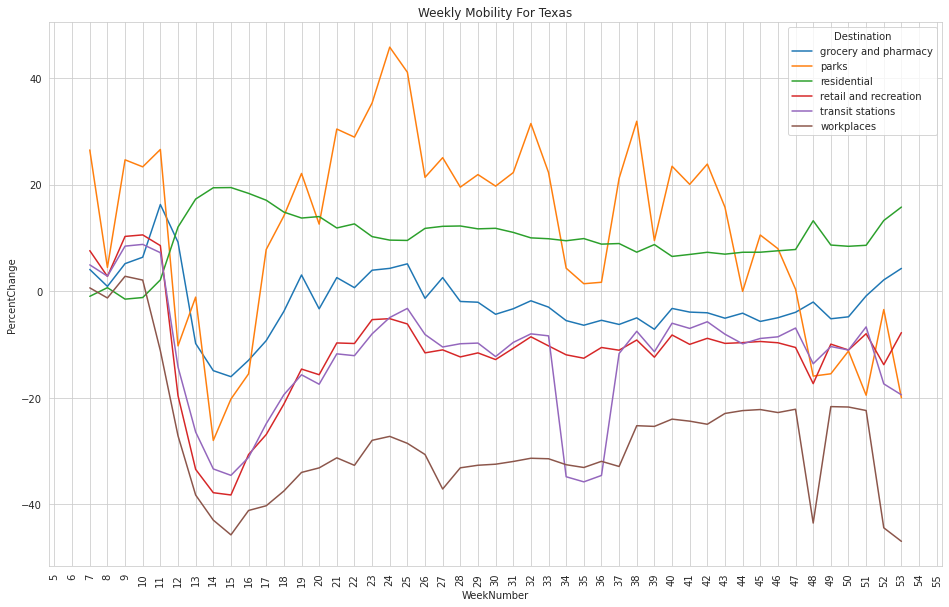

In [71]:
#set whitegrid to have grids in plots
sns.set_style("whitegrid")
#line plot that shows average mobility for the state of Texas during the year by week number
fig, ax=plt.subplots(figsize=(16,10))
scatter = sns.lineplot(x=mobility_txm.loc[mobility_txm['sub_region_1'] == 'Texas', 'WeekNumber'],
                             y=mobility_txm.loc[mobility_txm['sub_region_1'] == 'Texas', 'PercentChange'],
                             hue=mobility_txm['Destination'])
#customize the plot
plt.title("Weekly Mobility For Texas")
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=100)

People in Texas spent more time at the parks during the pandemic and less time in the workplace.  We also saw a reduction in retail, recreation, and transit station visits.  The pharmacy and groceries remained close to the baseline. There was also an increase in the amount of time people spent at home.  

## Hypothesis Test 
### H0 = the mobility did not change from the baseline during March and April (Weeks 10 - 18)
### Ha = the mobility did decrease from the baseline during March and April

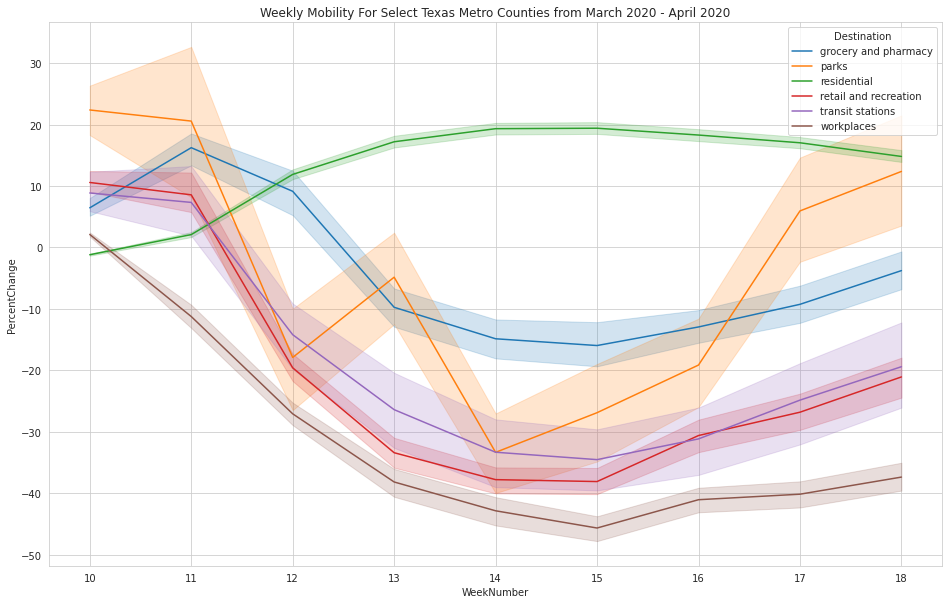

In [73]:
# Plot the Mobility Percent Change from the Baseline from the Shutdown Weeks (10-18) 
mobility_weeks = metro_county[(metro_county['WeekNumber'] >9) & (metro_county['WeekNumber'] < 19) ]
fig, ax=plt.subplots(figsize=(16,10))
scatter = sns.lineplot(x=mobility_weeks['WeekNumber'], y=mobility_weeks['PercentChange'],
                             hue=mobility_weeks['Destination'])
#customize the plot
plt.title("Weekly Mobility For Select Texas Metro Counties from March 2020 - April 2020")
plt.xticks(rotation=0)
plt.locator_params(axis='x', nbins=9)

In [75]:
#Percentage of null values in the Percent Change columns
print('Null values', mobility_weeks['PercentChange'].isna().sum()/mobility_weeks['PercentChange'].count())
#Drop the rows with null values
mobility_nonull = mobility_weeks.dropna()
#Percentage of null values in the Percent Change columns
print('Null values after dropping the nulls: ', mobility_nonull['PercentChange'].isna().sum()/mobility_nonull['PercentChange'].count())

Null values 0.12701252236135957
Null values after dropping the nulls:  0.0


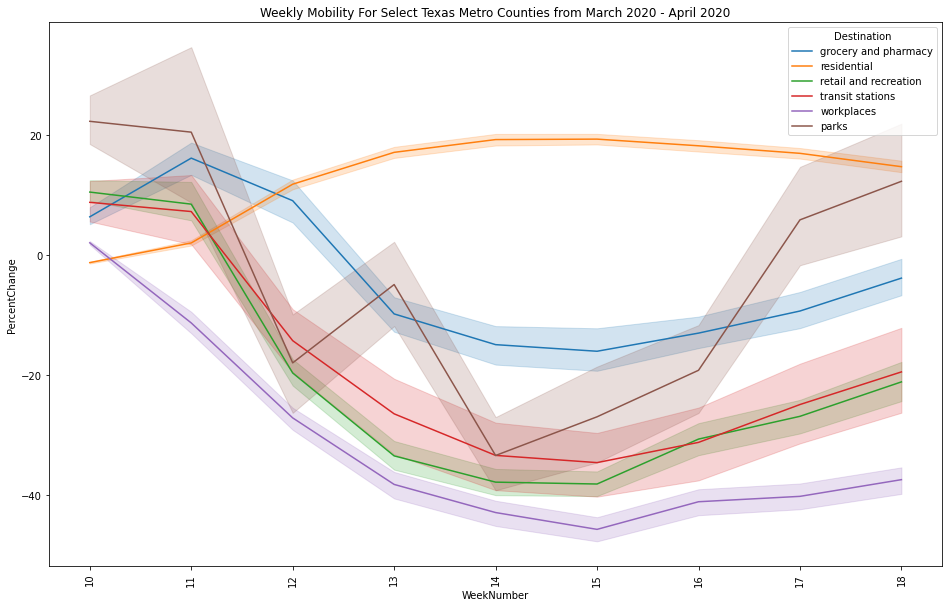

In [15]:
fig, ax=plt.subplots(figsize=(16,10))
scatter = sns.lineplot(x=mobility_nonull['WeekNumber'], y=mobility_nonull['PercentChange'],
                             hue=mobility_nonull['Destination'])
#customize the plot
plt.title("Weekly Mobility For Select Texas Metro Counties from March 2020 - April 2020")
plt.xticks(rotation=90)
plt.locator_params(axis='x', nbins=9)

In [16]:
# imports for Hypothesis testing
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels
from scipy import stats
from pingouin import pairwise_ttests #this is for performing the pairwise tests

In [76]:
Weeks = [10, 11, 12, 13, 14, 15, 16, 17, 18]
Destinations = ['grocery and pharmacy', 'residential', 'retail and recreation', 'workplaces']
Results = []
for w in Weeks:
    for d in Destinations:
        T, p = stats.ttest_1samp(mobility_nonull[(mobility_nonull['WeekNumber']== w) & (mobility_nonull['Destination']== d)]['PercentChange'], popmean=0.0)
        Results.append(p/2)
                  

In [59]:
Results

[1.5858379584772515e-10,
 1.9808457943083836e-17,
 9.881566954620432e-14,
 1.204960790116165e-13,
 6.870423521925509e-14,
 1.1391788409515711e-10,
 7.715544928910655e-06,
 3.5172459189833144e-14,
 1.2657368896801055e-05,
 3.5574394181121465e-24,
 2.6537714369107995e-18,
 6.1540795288925e-26,
 1.9089585237038872e-07,
 3.606712241679263e-26,
 9.288862359379133e-25,
 6.519729380031085e-28,
 8.65305927314324e-11,
 1.1078073751535556e-27,
 3.896834901680469e-28,
 1.1629518730830674e-29,
 3.750470077846825e-10,
 6.5013015391556844e-28,
 8.37495218745956e-28,
 4.100885603303113e-32,
 8.517112597731544e-11,
 3.345170420869773e-27,
 3.817031523359289e-21,
 1.586342271171291e-29,
 7.594203358322063e-07,
 7.223796447184908e-26,
 1.8655913279670236e-18,
 4.2224941644268825e-29,
 0.01257527183772514,
 8.538949922885622e-24,
 2.6244809760080065e-14,
 1.0647571229325414e-27]

In [115]:
groc = [Results[4*i] for i in range(0,9)]
resi = [Results[4*i+1] for i in range(0,9)]
retail = [Results[4*i+2] for i in range(0,9)]
work = [Results[4*i+3] for i in range(0,9)]


All of the P values are lower than the alpha = 0.05 for a one-sided T test. Thus we have to reject the null hypothesis that the mobility data was the same before the shutdowns as aft

In [ ]:
#violin plot to show Metro Area Mobility mean for the year by Destination and percent change
sns.catplot(x='Destination', y='PercentChange', hue='metro_area', kind='violin', data=mobility_metro, height=12, aspect=25/20)

When comparing the activity of each metro area, there are a few things that stand out.  Dallas showed the highest increase in park visits and Austin was close to the baseline.  The baseline was only the first 5 weeks of the year, but the weather was nice all over Texas.  It wouldnt have impacted the ability to go outside as much as other states.  People in Austin typically spend more time at parks which could explain why they remained near the baseline.  I also noticed that transit stations had more visits compared to the baseline than other metro areas.  Workplace was the lowest below baseline in each metro area, and people in each metro area spent more time at home. 

In [ ]:
#Create scatterplots to show trends for each metroplex by week of the year
#plot Destinations for each metroplex
fig, ax=plt.subplots(figsize=(18,18))
for i, city in enumerate(metro):
    plt.subplot(2,2,i+1)
    scatter = sns.scatterplot(x=mobility_metro.loc[mobility_metro['metro_area'] == city, 'WeekNumber'],
                             y=mobility_metro.loc[mobility_metro['metro_area'] == city, 'PercentChange'],
                             hue=mobility_metro['Destination'])
    #customize the plot
    #ax.set(title='TX Metroplex Area Pandemic Mobility',
          #xlabel='Week',
          #ylabel='Percent From Baseline')
    plt.title("Mobility For " +str(city))
    plt.xticks(rotation=90)
   

Looking at the weekly data will show what people were doing in each metro area during the year.  You can see negative spikes in each category except residence around holiday times.  It has a positive spike around those times.  Alot of the other trends are consistent around the state.  

In [ ]:
#get number of counties in each metroplex
print('Number of Counties in Dallas: ' + str(len(Dallas_Metroplex)))
print('Number of Counties in Houston: ' + str(len(Houston_Metroplex)))
print('Number of Counties in Austin: ' + str(len(Austin_Metroplex)))
print('Number of Counties in San Antonio: ' + str(len(San_Antonio_Metroplex)))
      

In [ ]:
#get ordereddict from collections to eliminate duplicate legend labels
from collections import OrderedDict
#create plots to show trends for each county in Dallas Metroplex
fig, ax=plt.subplots(figsize=(15,18), sharex=True, sharey=True)
for i, county in enumerate(Dallas_Metroplex):
    plt.subplot(7,2,i+1)
    line = sns.lineplot(x=metro_county.loc[(metro_county['sub_region_2'] == county) & (metro_county['metro_area'] == 'Dallas Metroplex'), 'WeekNumber'],
                             y=metro_county.loc[(metro_county['sub_region_2'] == county) & (metro_county['metro_area'] == 'Dallas Metroplex'), 'PercentChange'],
                             hue=metro_county['Destination'])
    #customize the plot
    line.get_legend().remove()
    plt.title("Weekly 2020 Mobility For " +str(county))
    plt.xticks(rotation=90)
    line.set(xlabel=None)
    line.set(xticklabels=[])
    fig.suptitle('Dallas Metroplex Weekly Mobility Data By County')
    plt.locator_params(axis='x', nbins=17)

    #we only want one legend instead of a legend in each subplot
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys())


Dallas Metroplex- Hood and Kaufman saw an increase in grocery and pharmacy.  Hood County also saw a decrease in parks which is different from other counties.  Transit did not decrease in wise county like it did in other counties.  All counties saw an increase in residential and decrease in workplace.  There were a few counties who didnt increase much over the baseline in residential.  These counties are the more rural suburbs where people already spent a lot of time at home.  

In [ ]:
#create plots to show trends for each county in Dallas Metroplex
fig, ax=plt.subplots(figsize=(15,18), sharex=True, sharey=True)
for i, county in enumerate(Houston_Metroplex):
    plt.subplot(5,2,i+1)
    line = sns.lineplot(x=metro_county.loc[(metro_county['sub_region_2'] == county) & (metro_county['metro_area'] == 'Houston Metroplex'), 'WeekNumber'],
                             y=metro_county.loc[(metro_county['sub_region_2'] == county) & (metro_county['metro_area'] == 'Houston Metroplex'), 'PercentChange'],
                             hue=metro_county['Destination'])
    #customize the plot
    line.get_legend().remove()
    plt.title("Weekly 2020 Mobility For " +str(county))
    plt.xticks(rotation=90)
    line.set(xlabel=None)
    #line.set(xticklabels=[])
    fig.suptitle('Houston Metroplex Weekly Mobility Data By County')
    plt.locator_params(axis='x', nbins=17)
    
    #we only want one legend instead of a legend in each subplot
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys())

Houston Metroplex - Harris County did the best job of staying at home.  Residential is high and all of the others are below the baseline with transit and workplace being the lowest.  Liberty had an increase of grocery and pharmacy.  Galveston county has transit way above the baseline and also had high numbers for parks.  Transit was also higher than baseline in a few other counties.  You can also see grocery and residential above baseline in most of the counties. 

In [ ]:
#create plots to show trends for each county in Dallas Metroplex
fig, ax=plt.subplots(figsize=(15,18), sharex=True, sharey=True)
for i, county in enumerate(Austin_Metroplex):
    plt.subplot(3,2,i+1)
    line = sns.lineplot(x=metro_county.loc[(metro_county['sub_region_2'] == county) & (metro_county['metro_area'] == 'Austin Metroplex'), 'WeekNumber'],
                             y=metro_county.loc[(metro_county['sub_region_2'] == county) & (metro_county['metro_area'] == 'Austin Metroplex'), 'PercentChange'],
                             hue=metro_county['Destination'])
    #customize the plot
    line.get_legend().remove()
    plt.title("Weekly 2020 Mobility For " +str(county))
    plt.xticks(rotation=90)
    line.set(xlabel=None)
    #line.set(xticklabels=[])
    fig.suptitle('Austin Metroplex Weekly Mobility Data By County')
    plt.locator_params(axis='x', nbins=17)
    
    #we only want one legend instead of a legend in each subplot
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys())

Austin Metropex - Hays and Caldwell had an increase in transit with a decrease in workplace which is different than most counties.  Travis county did a good job of staying at home.  Residential is far above the baseline and everything else is below. 

In [ ]:
#create plots to show trends for each county in Dallas Metroplex
fig, ax=plt.subplots(figsize=(15,18), sharex=True, sharey=True)
for i, county in enumerate(San_Antonio_Metroplex):
    plt.subplot(4,2,i+1)
    line = sns.lineplot(x=metro_county.loc[(metro_county['sub_region_2'] == county) & (metro_county['metro_area'] == 'San Antonio Metroplex'), 'WeekNumber'],
                             y=metro_county.loc[(metro_county['sub_region_2'] == county) & (metro_county['metro_area'] == 'San Antonio Metroplex'), 'PercentChange'],
                             hue=metro_county['Destination'])
    #customize the plot
    line.get_legend().remove()
    plt.title("Weekly 2020 Mobility For " +str(county))
    plt.xticks(rotation=90)
    line.set(xlabel=None)
    #line.set(xticklabels=[])
    fig.suptitle('San Antonio Metroplex Weekly Mobility Data By County')
    plt.locator_params(axis='x', nbins=17)
    
    #we only want one legend instead of a legend in each subplot
    handles, labels = plt.gca().get_legend_handles_labels()
    by_label = OrderedDict(zip(labels, handles))
    fig.legend(by_label.values(), by_label.keys())

San Antonio Metroplex - Comal county saw a huge increase in parks and everything else was close to or below the baseline while Medina County saw a huge decrease in parks. Workplace was low in every county and residential was above the baseline. 
